# A Practical Introduction to fMRI with Python
## Overview
1. Load the fMRI data
2. Visualize the fMRI data
    1. Visualize the fMRI time course
        1. Single voxel time course
        2. Whole-brain carpet plot
    2. Visualize the 3D data
    3. Make a video of the fMRI 4D data
3. Parcellation
    1. DiFuMo Atlas
4. Functional Connectivity
    1. ROI-level whole-brain FC (controlling for different confounding factors)
    2. Voxel-level seed-based connectivity
-----
## Environment requirement
1. Python version: 3.9
2. Packages\
nibabel==3.2.2 \
nilearn==0.9.1\
seaborn==0.11.2\
matplotlib==3.4.3\
numpy==1.21.2\
cv2==4.9.0\
re==2.2.1

-----
## References
1. Pierre Bellec, Elizabeth DuPre, Greg Kiar, and Jake Vogel (Dec 2018), Machine Learning with Nilearn (https://brainhack101.github.io/introML-book/intro.html)
2. 2019 UI Brainhack: Neuroimaging in Python Tutorial (https://www.youtube.com/watch?v=0KmuaOKMER0)
3. Ariel Rokum and Tal Yarkoni (2023), Data Science for Neuroimaging: An Introduction, Princeton University Press (https://neuroimaging-data-science.org/root.html#)
4. Content for the workshop in Cambridge 2018 - Functional connectivity and resting state (https://github.com/miykael/workshop_cambridge/blob/master/notebooks/functional_connectivity.ipynb)
5. Nilearn Documentation (https://nilearn.github.io/dev/index.html)


## 1. Load the fMRI data

In [352]:
import nibabel as nib
import os
from nilearn import image, masking, plotting, datasets
from nilearn.plotting import plot_carpet
from nilearn.maskers import NiftiMasker, NiftiMapsMasker, NiftiSpheresMasker
from nilearn.connectome import ConnectivityMeasure
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re

file_pathway = 'data/'
bold_filename = 'ExamplefMRI_EPI2MNI_sm_nr_short.nii.gz' #nii.gz - volumetric fMRI data
img_bold = nib.load(os.path.join(file_pathway, bold_filename))
print(type(img_bold))
print(img_bold.shape)
header = img_bold.header
print(header)
img_tr = header['pixdim'][4]
print('TR =',img_tr)

<class 'nibabel.nifti1.Nifti1Image'>
(91, 109, 91, 100)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [  4  91 109  91 100   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   2.   2.   2.   1.4  1.   1.   1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 90
slice_code      : unknown
xyzt_units      : 10
cal_max         : 2844.2131
cal_min         : -0.11006172
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset

In [296]:
#Load Brain Mask
brain_mask = nib.load(os.path.join(file_pathway, 'MNI152_T1_2mm_brain_Mask.nii'))

#Preprocess resting-state fMRI data
low_pass_thre=0.15
high_pass_thre=0.01
img_bold_preprocessed = image.clean_img(
    img_bold,
    mask_img=brain_mask,
    detrend=True,
    low_pass=low_pass_thre, 
    high_pass=high_pass_thre, 
    t_r=img_tr,
    standardize=True,
    ensure_finite=True,
)
img_bold_smooth = image.smooth_img(img_bold_preprocessed, 5.0) #Smoothing strength, as a full-width at half maximum, in millimeters
print(img_bold_smooth.shape)

(91, 109, 91, 100)


In [297]:
# img_bold_smooth.to_filename("data/more_smooth_data.nii.gz")

## 2. Visualize the fMRI data
Nilearn Examples: https://nilearn.github.io/dev/auto_examples/01_plotting/index.html

### 2.1 Plot the fMRI time course
(Image courtesy of Dr. Bayrak)\
[<img src="fig/fmri_4d.png" width="600" align="left"/>](fmri_4d.png)

#### 2.1.1 Plot the fMRI time course - Voxel time course
(Image courtesy of Dr. Bayrak)\
[<img src="fig/fmri_voxel_time_course.png" width="800" align="left">](fmri_voxel_time_course.png)

Reference\
deep-physio-recon repo: https://github.com/neurdylab/deep-physio-recon/blob/master/JOURNAL-NAME-2022/preprocessing/visualize_raw_data_rs.ipynb

In [298]:
from nilearn.maskers import NiftiMasker
import seaborn as sns

brain_masker = NiftiMasker(
    detrend=True,
    low_pass=low_pass_thre,
    high_pass=high_pass_thre,
    t_r=img_tr,
    standardize="zscore",
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
    mask_strategy="whole-brain-template",
)
brain_masker_raw = NiftiMasker(
    detrend=False,
    standardize=False,
    t_r=img_tr,
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
    mask_strategy="whole-brain-template",
)
brain_time_series = brain_masker.fit_transform(
    os.path.join(file_pathway, bold_filename),
)
brain_time_series_raw = brain_masker_raw.fit_transform(
    os.path.join(file_pathway, bold_filename),
)
print(f"Brain time series shape: ({brain_time_series.shape})")

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/joblib/memory.py:614: UserWarning: Cannot inspect object functools.partial(<function compute_brain_mask at 0x1663fa940>, mask_type='whole-brain'), ignore list will not work.
  return hashing.hash(filter_args(self.func, self.ignore, args, kwargs),


Brain time series shape: ((100, 216734))


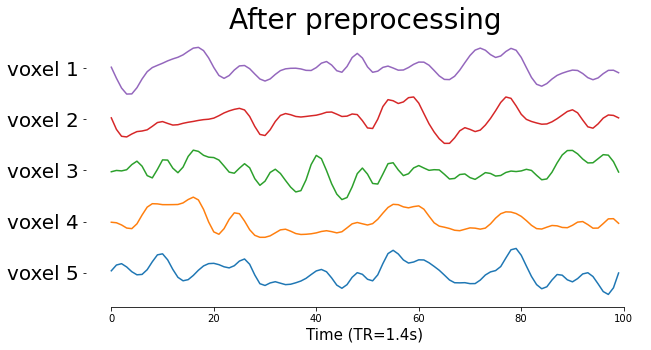

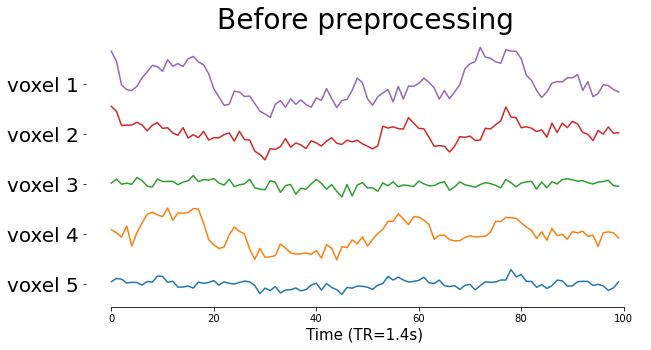

In [299]:
# demean and offset for visualization purposes only
Yd = brain_time_series-np.mean(brain_time_series, axis=0)

# add offset (space the y-axis appropriately for visual inspection - no longer the accurate values)
offset = 5
num_voxel = 5
Y_do = np.zeros((Yd.shape[0],num_voxel))
labels = []
for i in range(num_voxel):
    Y_do[: , i] = Yd[:, i*100] + i*offset
    labels.append('voxel '+str(num_voxel-i))

# plot extracted time-series signals
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(Y_do)

# show labels
ax.set_yticks(np.mean(Y_do, axis=0))
ax.set_yticklabels(labels, fontdict={'fontsize': 20, 'fontweight': 'medium'})

sns.despine(left=True, trim=True)
plt.title('After preprocessing', fontsize=28)
plt.xlabel("Time (TR=1.4s)",fontsize=15)
plt.show()

# demean and offset for visualization purposes only
Yd_raw = brain_time_series_raw-np.mean(brain_time_series_raw, axis=0)

# add offset (space the y-axis appropriately for visual inspection - no longer the accurate values)
offset = 50
num_voxel = 5
Y_do = np.zeros((Yd_raw.shape[0],num_voxel))
labels = []
for i in range(num_voxel):
    Y_do[: , i] = Yd_raw[:, i*100] + i*offset
    labels.append('voxel '+str(num_voxel-i))

# plot extracted time-series signals
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(Y_do)

# show labels
ax.set_yticks(np.mean(Y_do, axis=0))
ax.set_yticklabels(labels, fontdict={'fontsize': 20, 'fontweight': 'medium'})

sns.despine(left=True, trim=True)
plt.title('Before preprocessing', fontsize=28)
plt.xlabel("Time (TR=1.4s)",fontsize=15)
plt.show()

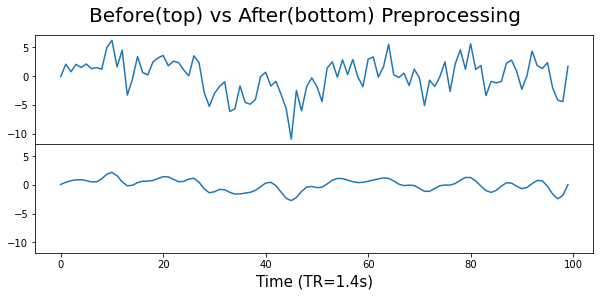

In [302]:
fig = plt.figure()
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Before(top) vs After(bottom) Preprocessing',fontsize=20)
fig.set_figwidth(10)
axs[0].plot(Yd_raw[:, 1])
axs[1].plot(Yd[:, 1])
plt.xlabel("Time (TR=1.4s)",fontsize=15)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

#### 2.1.2 Carpet plot
Visualizing fMRI global pattern over time\
Reference - https://nilearn.github.io/dev/auto_examples/01_plotting/plot_carpet.html#sphx-glr-auto-examples-01-plotting-plot-carpet-py, https://nilearn.github.io/dev/modules/generated/nilearn.plotting.plot_carpet.html

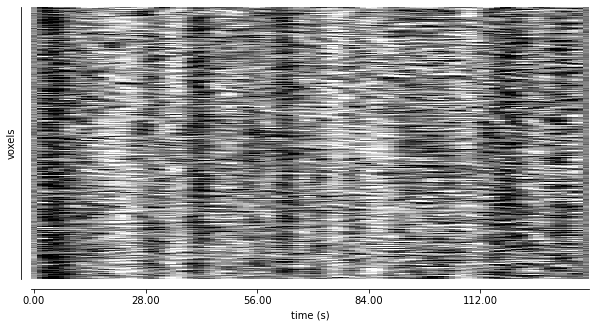

In [303]:
from nilearn.plotting import plot_carpet

display = plot_carpet(
    img_bold_smooth,
    brain_mask,
    t_r=img_tr,
    detrend=True
)
plt.show()

### 2.2 3D fMRI plot 
Reference\
Nilearn Example: https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_3d_and_4d_niimg.html#sphx-glr-auto-examples-00-tutorials-plot-3d-and-4d-niimg-py , https://nilearn.github.io/dev/auto_examples/01_plotting/plot_demo_more_plotting.html#sphx-glr-auto-examples-01-plotting-plot-demo-more-plotting-py

(91, 109, 91)


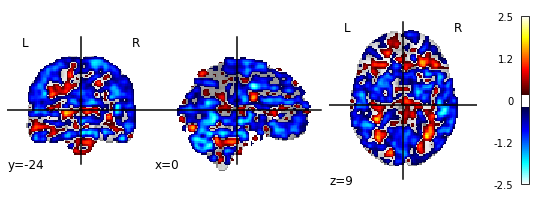

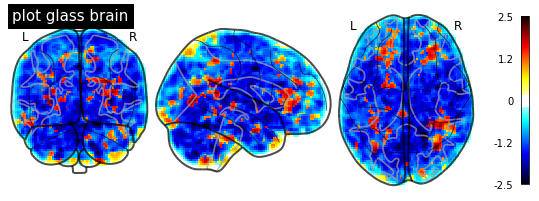

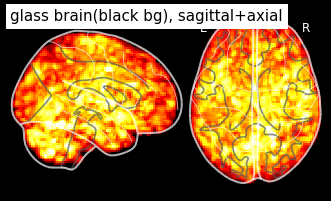

In [304]:
import matplotlib.pyplot as plt
from nilearn import plotting, image
import numpy as np

# Plotting MNI152 template
# plotting.plot_img((os.path.join(file_pathway, 'MNI152_T1_2mm_brain.nii.gz')), title='MNI152 template')

# Plotting the second volume in a 4D file
# img_bold = nib.load(os.path.join(file_pathway, bold_filename))
sec_rsn = image.index_img(img_bold_smooth, 1)
print(sec_rsn.shape)
plotting.plot_stat_map(sec_rsn,threshold=0.2)

# Glass brain plot
plotting.plot_glass_brain(
    sec_rsn, 
    title="plot glass brain",
    threshold=0.2, 
    colorbar=True,
    plot_abs=False
)

plotting.plot_glass_brain(
    sec_rsn,
    title="glass brain(black bg), sagittal+axial",
    black_bg=True,
    display_mode="xz", #x-saggital,y-coronal,z-axial
    threshold=0.2,
)

# Visualizing three views along multiple rows and columns
# plotting.plot_stat_map(
#     sec_rsn,
#     display_mode="mosaic",
#     cut_coords=(5,5,5), #change slices
#     title="display_mode='mosaic'",
# )

### 2.3 Make a video of the 4D fMRI data
Reference\
Stackoverflow: https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python

In [305]:
import cv2
import os
import re

# Looping through selected volumes in a 4D file (plotting signal amplitude)
slice_start = 0
slice_end = 20
slice_inc = 1
selected_volumes = image.index_img(img_bold_smooth, slice(slice_start, slice_end, slice_inc))
slice_ind = range(slice_start, slice_end, slice_inc)
ct = 0
images = []
for img in image.iter_img(selected_volumes):
    # img is now an in-memory 3D img
    # plotting.plot_stat_map(
    #     img, 
    #     display_mode='z', #z-axial,x-sagittal,y-coronal 
    #     cut_coords=[-20, 0, 20], #z-coordinates
    #     title='Slice ' + str(slice_ind[ct]),
    #     colorbar=True,
    #     threshold=1,
    # )
    plotting.plot_glass_brain(
        img, 
        title="plot glass brain (TR="+str(ct+1)+")",
        threshold=0.01,
        vmin=-3,
        vmax=3,
        colorbar=True,
        plot_abs=False
    )
    # plotting.show()
    plt.savefig('output/images/fig'+str(ct+1)+'.png')
    plt.close()
    ct = ct + 1
    images.append('fig'+str(ct)+'.png')

image_folder = 'output/images'
video_name = 'output/video.mp4'

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
print(height, width, layers)

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 5.0, (width,height))
for image0 in images:
    video.write(cv2.imread(os.path.join(image_folder, image0)))
cv2.destroyAllWindows()
video.release()

187 525 3


## 3. Parcellation
- For probabilistic atlas, use nilearn.NiftiMapsMasker and nilear.plotting.plot_prob_atlas (e.g. DiFuMo)
- For non-overlapping atlas, use nilearn.NiftiLabelsMasker and nilear.plotting.plot_roi (e.g. Schaefer)

(Image courtesy of Dr. Bayrak)\
[<img src="fig/fmri_roi_time_course.png" width="800" align="left"/>](fmri_roi_time_course.png)

Reference\
Nilearn Example: https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py, 
For different atlases: https://nilearn.github.io/dev/auto_examples/01_plotting/plot_prob_atlas.html

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


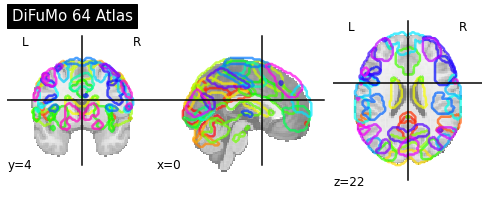

In [353]:
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
dim = 64
difumo = datasets.fetch_atlas_difumo(
    dimension=dim, resolution_mm=2, legacy_format=False
)
# Loading atlas image stored in 'maps'
atlas_filename = difumo["maps"]
# Loading atlas data stored in 'labels'
labels = difumo["labels"]
plotting.plot_prob_atlas(atlas_filename, title='DiFuMo 64 Atlas')
plotting.show()

In [307]:
masker = NiftiMapsMasker(
    maps_img=atlas_filename,
    verbose=5,
    standardize='zscore',
    low_pass=low_pass_thre,
    high_pass=high_pass_thre,
    t_r=img_tr,
    detrend=True,
    # memory="nilearn_cache"
)
masker.fit(os.path.join(file_pathway, bold_filename))
roi_time_series = masker.transform(os.path.join(file_pathway, bold_filename)) #Takes raw data here
print(roi_time_series.shape)

[NiftiMapsMasker.fit] loading regions from /Users/bellewang/nilearn_data/difumo_atlases/64/2mm/maps.nii.gz
Resampling maps
[NiftiMapsMasker.transform_single_imgs] Loading data from data/ExamplefMRI_EPI2MNI_sm_nr_short.nii.gz
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
(100, 64)


## 4. Functional Connectivity
### 4.1 ROI-based Analysis: with or without motion regression/global signal regression
Reference\
Nilear Example: https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py, https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_atlas_comparison.html#sphx-glr-auto-examples-03-connectivity-plot-atlas-comparison-py

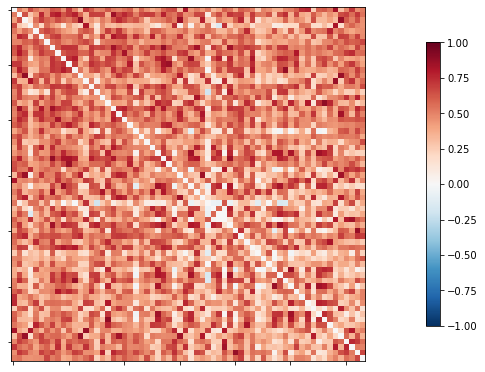

In [350]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind="correlation")
correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]

# Plot the correlation matrix
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
display=plotting.plot_matrix(
    correlation_matrix,
    vmax=1.0,
    vmin=-1.0,
    # labels=labels['difumo_names'].tolist(),
    # title='No Confounds'
)
plotting.show()

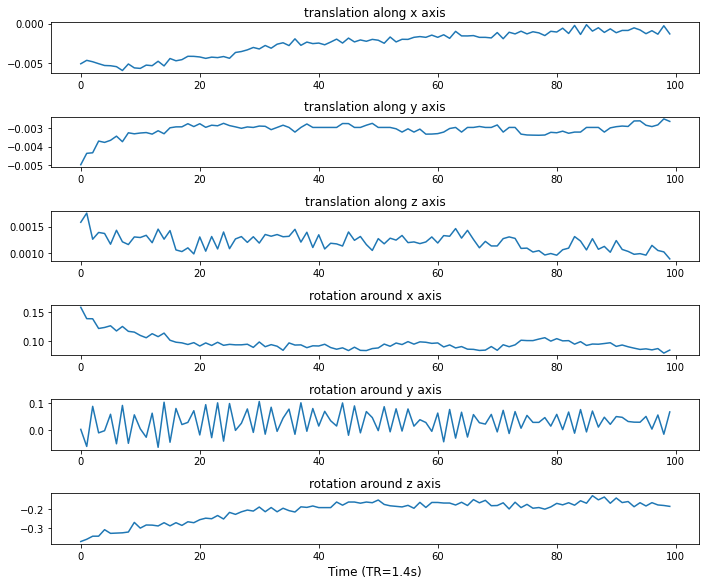

In [315]:
# Motion regression
conf_filename = 'ExamplefMRI_mcf_motion_params.par'
motion_param = np.genfromtxt(os.path.join(file_pathway, conf_filename), dtype=float)
motion_param = motion_param[0:100,:]
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)
ax4 = fig.add_subplot(614)
ax5 = fig.add_subplot(615)
ax6 = fig.add_subplot(616)
ax1.plot(motion_param[:, 0])
ax2.plot(motion_param[:, 1])
ax3.plot(motion_param[:, 2])
ax4.plot(motion_param[:, 3])
ax5.plot(motion_param[:, 4])
ax6.plot(motion_param[:, 5])
ax1.title.set_text('translation along x axis')
ax2.title.set_text('translation along y axis')
ax3.title.set_text('translation along z axis')
ax4.title.set_text('rotation around x axis')
ax5.title.set_text('rotation around y axis')
ax6.title.set_text('rotation around z axis')
fig.tight_layout()
plt.xlabel("Time (TR=1.4s)",fontsize=12)
plt.show()

(100, 12)
[NiftiMapsMasker.fit_transform] loading regions from /Users/bellewang/nilearn_data/difumo_atlases/64/2mm/maps.nii.gz
[NiftiMapsMasker.transform_single_imgs] Loading data from data/ExamplefMRI_EPI2MNI_sm_nr_short.nii.gz
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals


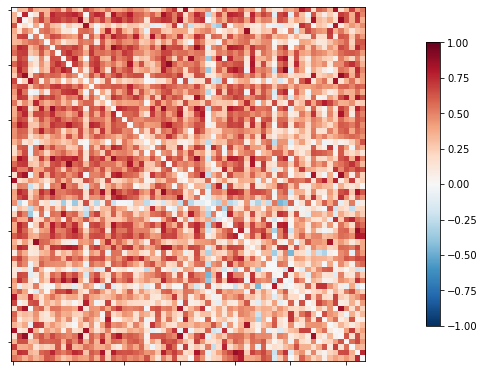

In [351]:
motion_deriv = motion_param[1:motion_param.shape[0], :] - motion_param[0:motion_param.shape[0] - 1, :]
motion_deriv = np.vstack((np.zeros((1, 6)), motion_deriv))
motion_reg = np.hstack((motion_param, motion_deriv))
print(motion_reg.shape)

mot_fmri_matrix = masker.fit_transform(os.path.join(file_pathway, bold_filename),
                                               confounds=motion_reg)

mot_correlation_matrix = correlation_measure.fit_transform([mot_fmri_matrix])[0]
np.fill_diagonal(mot_correlation_matrix, 0)
display=plotting.plot_matrix(
    mot_correlation_matrix,
    vmax=1.0,
    vmin=-1.0,
    # title='With motion regression'
)
plotting.show()

In [354]:
# roi_ind=8
# plt.figure(figsize=(10,3))
# plt.plot(mot_fmri_matrix[:,roi_ind])
# plt.plot(roi_time_series[:,roi_ind])
# plt.legend(['motion-regressed', 'original']) 

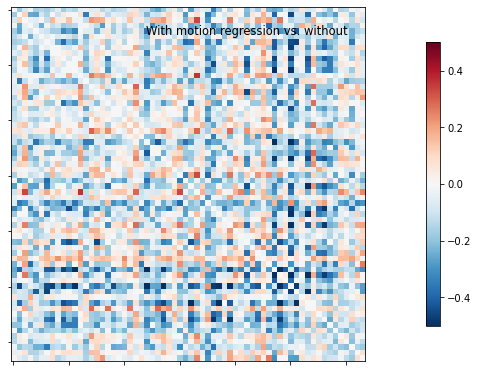

In [318]:
display=plotting.plot_matrix(
    mot_correlation_matrix-correlation_matrix,
    vmax=0.5,
    vmin=-0.5,
    title='With motion regression vs. without'
)
plotting.show()

(100, 13)
[NiftiMapsMasker.fit_transform] loading regions from /Users/bellewang/nilearn_data/difumo_atlases/64/2mm/maps.nii.gz
[NiftiMapsMasker.transform_single_imgs] Loading data from data/ExamplefMRI_EPI2MNI_sm_nr_short.nii.gz
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals


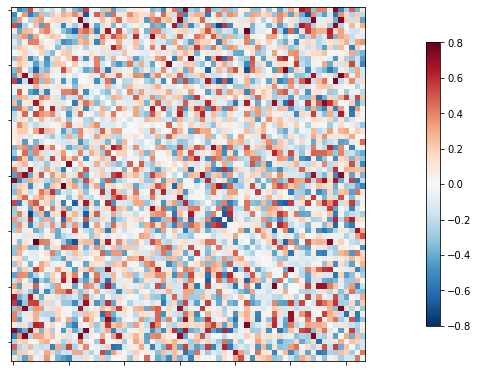

In [319]:
#Global Signal Regression
gs_reg = np.average(brain_time_series,axis=1)
gs_reg = gs_reg.reshape(-1,1)
motion_gs_reg = np.hstack((motion_reg, gs_reg))
print(motion_gs_reg.shape)

mot_gs_fmri_matrix = masker.fit_transform(os.path.join(file_pathway, bold_filename),
                                               confounds=motion_gs_reg)
mot_gs_correlation_matrix = correlation_measure.fit_transform([mot_gs_fmri_matrix])[0]
np.fill_diagonal(mot_gs_correlation_matrix, 0)
display=plotting.plot_matrix(
    mot_gs_correlation_matrix,
    vmax=0.8,
    vmin=-0.8,
#     title='With motion regression & GSR'
)
plotting.show()

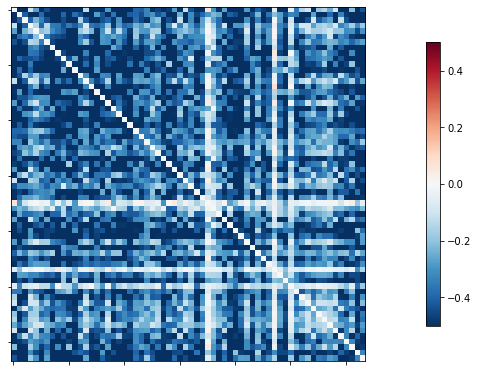

In [320]:
display=plotting.plot_matrix(
    mot_gs_correlation_matrix-mot_correlation_matrix,
    vmax=0.5,
    vmin=-0.5,
    # title='With motion regression & GSR vs. with only motion regression'
)
plotting.show()

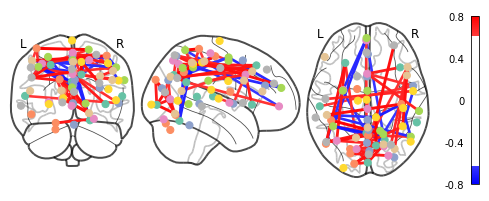

In [321]:
# Plot connectome
coordinates = plotting.find_probabilistic_atlas_cut_coords(
    maps_img=difumo["maps"]
)

# We threshold to keep only the 3% of edges with the highest (absolute) value
plotting.plot_connectome(
    mot_gs_correlation_matrix,
    coordinates, 
    edge_threshold="97%", 
    colorbar=True
)

plotting.show()

### 4.2 Plotting the seed-to-voxel correlation map
Reference\
Nilearn Example: https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html

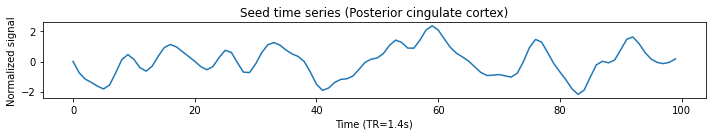

In [324]:
#1-Extract seed time series
pcc_coords = [(0, -52, 18)]
from nilearn.maskers import NiftiSpheresMasker

seed_masker = NiftiSpheresMasker(
    pcc_coords,
    radius=8,
    detrend=True,
    standardize="zscore",
    low_pass=low_pass_thre,
    high_pass=high_pass_thre,
    t_r=img_tr,
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
)
seed_time_series = seed_masker.fit_transform(
    os.path.join(file_pathway, bold_filename),
)

plt.figure(figsize=(10,2))
plt.plot(seed_time_series)
plt.title("Seed time series (Posterior cingulate cortex)")
plt.xlabel("Time (TR=1.4s)")
plt.ylabel("Normalized signal")
plt.tight_layout()

In [325]:
#2-Whole brain time series
print(f"Seed time series shape: ({seed_time_series.shape})")
print(f"Whole brain time series shape: ({brain_time_series.shape})")

Seed time series shape: ((100, 1))
Whole brain time series shape: ((100, 216734))


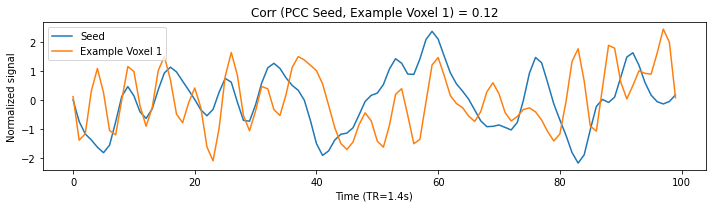

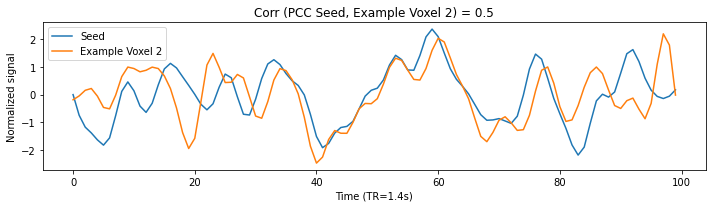

In [344]:
#3-Seed-based correlation (example voxel)
example_voxel=12000
temp_corr = np.corrcoef(seed_time_series.T,brain_time_series[:,example_voxel])[0][1]
temp_corr = np.round(temp_corr,2)
plt.figure(figsize=(10,3))
plt.plot(seed_time_series,label='Seed')
plt.plot(brain_time_series[:,example_voxel],label='Example Voxel 1')
plt.title("Corr (PCC Seed, Example Voxel 1) = "+str(temp_corr))
plt.xlabel("Time (TR=1.4s)")
plt.ylabel("Normalized signal")
plt.legend(loc="upper left")
plt.tight_layout()

example_voxel=93500
temp_corr = np.corrcoef(seed_time_series.T,brain_time_series[:,example_voxel])[0][1]
temp_corr = np.round(temp_corr,2)
plt.figure(figsize=(10,3))
plt.plot(seed_time_series,label='Seed')
plt.plot(brain_time_series[:,example_voxel],label='Example Voxel 2')
plt.title("Corr (PCC Seed, Example Voxel 2) = "+str(temp_corr))
plt.xlabel("Time (TR=1.4s)")
plt.ylabel("Normalized signal")
plt.legend(loc="upper left")
plt.tight_layout()


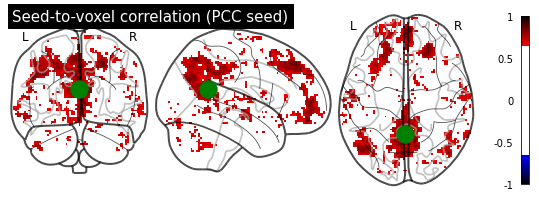

In [349]:
seed_to_voxel_correlations = (
    np.dot(brain_time_series.T, seed_time_series) / seed_time_series.shape[0]
)
seed_to_voxel_correlations_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations.T
)

display = plotting.plot_glass_brain(
    seed_to_voxel_correlations_img, 
    title="Seed-to-voxel correlation (PCC seed)",
    threshold=0.65, 
    colorbar=True,
    plot_abs=False,
    vmin=-1.0,
    vmax=1.0,
)
display.add_markers(
    marker_coords=pcc_coords, marker_color="g", marker_size=300
)
# At last, we save the plot as pdf.
display.savefig("output/pcc_seed_correlation.pdf")

## AFNI
### Youtube Videos: AFNI Bootcamp
https://www.youtube.com/@AFNIBootcamp/playlists
### Documentation
https://afni.nimh.nih.gov/pub/dist/doc/htmldoc/